# Prepare
## Dataset loading

In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import Callback
from tqdm import tqdm

train_raw = pd.read_excel('/home/competition/data/data/ai_competition_train.xlsx')
test_raw = pd.read_excel('/home/competition/data/data/ai_competition_test.xlsx')

train = np.array(train_raw['flux'])
test = np.array(test_raw['flux'])

print(train.shape, test.shape)

(5479,) (60,)


## Nan -> zero (Only train)

In [49]:
# NaN 값을 0.0으로 대체
nan_indices = np.isnan(train)
_mask = np.zeros(len(train))
train[nan_indices] = _mask[nan_indices]

# NaN 값을 대체한 결과 확인
print(train)
print(np.mean(train))
print("NaN 값의 개수:", np.sum(np.isnan(test)))


[ 94.8    96.93   97.71  ...   0.    128.634 143.651]
78.29537461215551
NaN 값의 개수: 0


## Cut zero (Only train)
- 인위적인 이동평균을 넣어주는 것은 오히려 악영향이라고 생각 > 끊어진 부분 강제로 이어붙임으로서 그것 또한 노이즈하고 생각하기

In [50]:
train_cut = train[train != 0]
print(train_cut.shape)
print(np.mean(train_cut))

(4228,)
101.46176856669818


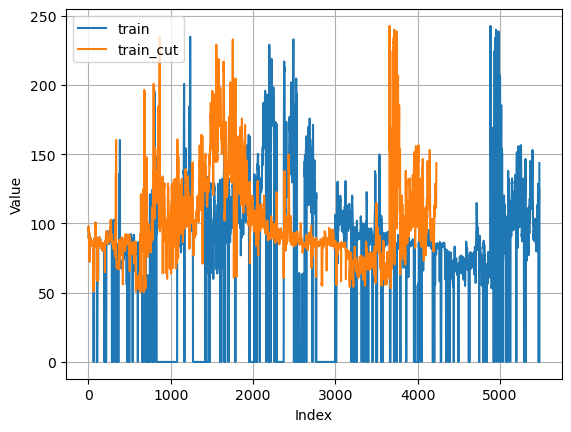

In [51]:
plt.figure()
plt.plot(train, label='train')
plt.plot(train_cut, label='train_cut')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Make dataset

In [52]:
# subtract mean
train_cut_sub_mean = train_cut - np.mean(train_cut)
print(np.mean(train_cut_sub_mean), np.var(train_cut_sub_mean))

test_mean = np.mean(test)
test_sub_mean = test - test_mean
print(np.mean(test_sub_mean), np.var(test_sub_mean))

# windows shift
INPUT_DAYS = 60

train_x = np.zeros([INPUT_DAYS, 1])
train_y = np.zeros([1, 1])

print("x and y shape :", train_x.shape, train_y.shape)
for i in range(len(train_cut_sub_mean) - INPUT_DAYS - 1):
    train_x = np.concatenate(
        (train_x, train_cut_sub_mean[i:i+INPUT_DAYS, np.newaxis]), axis=1)
    train_y = np.concatenate(
        (train_y, train_cut_sub_mean[np.newaxis, i+INPUT_DAYS+1, np.newaxis]), axis=1)

print("x and y shape :", train_x.shape, train_y.shape)
train_x = train_x[:, 1:]
train_y = train_y[:, 1:]
train_x = train_x.T
train_y = train_y.T
print("x and y shape :", train_x.shape, train_y.shape)


1.118583833779382e-14 926.6917847239334
1.4210854715202004e-14 234.5757282247222
x and y shape : (60, 1) (1, 1)
x and y shape : (60, 4168) (1, 4168)
x and y shape : (4167, 60) (4167, 1)


In [53]:
loss_history = []


class LossHistory(Callback):
    def on_epoch_end(self, epoch, logs=None):
        loss_history.append(logs['loss'])


loss_callback = LossHistory()


---

# Model

In [54]:
model = keras.Sequential()
model.add(keras.layers.LSTM(units=80, input_shape=(INPUT_DAYS, 1)))
model.add(keras.layers.Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['RootMeanSquaredError'])


In [55]:
model.fit(train_x, train_y, epochs=40, batch_size=64, callbacks=[loss_callback])


Epoch 1/40
66/66 [==============================] - 4s 28ms/step - loss: 813.7139 - root_mean_squared_error: 28.5257
Epoch 2/40
66/66 [==============================] - 2s 28ms/step - loss: 639.5711 - root_mean_squared_error: 25.2897
Epoch 3/40
66/66 [==============================] - 2s 28ms/step - loss: 511.9780 - root_mean_squared_error: 22.6269
Epoch 4/40
66/66 [==============================] - 2s 28ms/step - loss: 428.6700 - root_mean_squared_error: 20.7043
Epoch 5/40
66/66 [==============================] - 2s 28ms/step - loss: 377.5585 - root_mean_squared_error: 19.4309
Epoch 6/40
66/66 [==============================] - 2s 28ms/step - loss: 341.6712 - root_mean_squared_error: 18.4844
Epoch 7/40
66/66 [==============================] - 2s 29ms/step - loss: 315.1997 - root_mean_squared_error: 17.7539
Epoch 8/40
66/66 [==============================] - 2s 28ms/step - loss: 293.7116 - root_mean_squared_error: 17.1380
Epoch 9/40
66/66 [==============================] - 2s 29ms/step

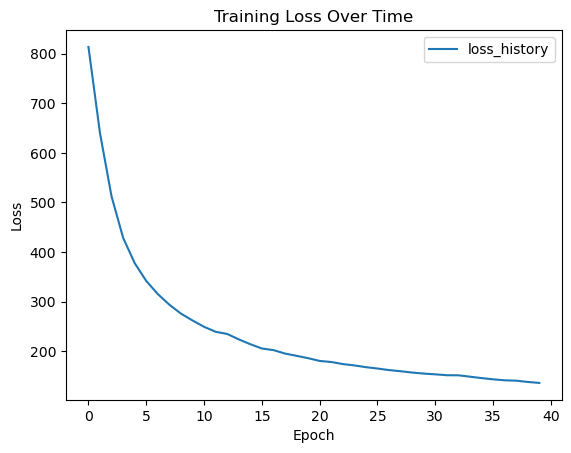

In [56]:

plt.plot(loss_history)
plt.title('Training Loss Over Time')
plt.legend(['loss_history', 'rmse_history'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


---

# Prediction

- input 60개로 61번째 예측
- 2번째 ~ 61번째로, 62번째 예측
- 90번째를 예측할 때 까지 반복하고, 61~90번째를 제출

  0%|          | 0/30 [00:00<?, ?it/s]

100%|██████████| 30/30 [00:02<00:00, 14.00it/s]


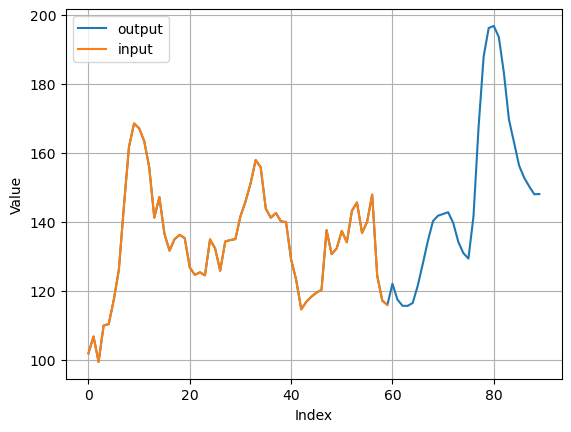

In [57]:
final_result = test_sub_mean
for i in tqdm(range(30)):
    _single_output = model(
        final_result[np.newaxis, i:i+INPUT_DAYS, np.newaxis]).numpy()
    final_result = np.concatenate((final_result, _single_output[0]), axis=0)    

# Subtract mean했던거 다시 더해주기
_summit = final_result[-30:]
_summit = _summit + test_mean

plt.figure()
plt.plot(final_result+test_mean, label='output')
plt.plot(test, label='input')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


## output xlsx file 생성

In [58]:
import datetime

current_time = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
df = pd.DataFrame({'date': np.array(range(1,31)), 'flux': _summit})

# DataFrame을 엑셀 파일로 내보내기
file_name = f'/home/competition/data/data/dev/{current_time}_output_{loss_history[-1]}.xlsx'
df.to_excel(file_name, index=False)

model_name = f'/home/competition/data/data/dev/{current_time}_model_{loss_history[-1]}.h5'
model.save(model_name)


/home/competition/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
